In [8]:
!pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.3/1.3 MB 252.2 kB/s eta 0:00:00


In [2]:
from IPython.display import clear_output
!pip install imutils
clear_output()
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb


In [1]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 99.7/99.7 MB 117.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:

import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")


All modules have been imported


In [28]:
import os

# Create the new folders
os.makedirs('TRAIN/YES', exist_ok=True)
os.makedirs('TRAIN/NO', exist_ok=True)
os.makedirs('TEST/YES', exist_ok=True)
os.makedirs('TEST/NO', exist_ok=True)
os.makedirs('VAL/YES', exist_ok=True)
os.makedirs('VAL/NO', exist_ok=True)

# Function to print the directory structure
def print_directory_structure(root_path):
    for root, dirs, files in os.walk(root_path):
        level = root.replace(root_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{sub_indent}{f}")

# Print the directory structure
print_directory_structure('../1.BrainTumor/Training/dataset')


dataset/
    NO/
        no0.jpg
        no1.jpg
        no10.jpg
        no100.jpg
        no1000.jpg
        no1001.jpg
        no1002.jpg
        no1003.jpg
        no1004.jpg
        no1005.jpg
        no1006.jpg
        no1007.jpg
        no1008.jpg
        no1009.jpg
        no101.jpg
        no1010.jpg
        no1011.jpg
        no1012.jpg
        no1013.jpg
        no1014.jpg
        no1015.jpg
        no1016.jpg
        no1017.jpg
        no1018.jpg
        no1019.jpg
        no102.jpg
        no1020.jpg
        no1021.jpg
        no1022.jpg
        no1023.jpg
        no1024.jpg
        no1025.jpg
        no1026.jpg
        no1027.jpg
        no1028.jpg
        no1029.jpg
        no103.jpg
        no1030.jpg
        no1031.jpg
        no1032.jpg
        no1033.jpg
        no1034.jpg
        no1035.jpg
        no1036.jpg
        no1037.jpg
        no1038.jpg
        no1039.jpg
        no104.jpg
        no1040.jpg
        no1041.jpg
        no1042.jpg
        no1043.jpg
        

In [29]:
IMG_PATH = "../1.BrainTumor/Training/dataset"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [31]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [33]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.64s/it]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7936\4189382919.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



1800 images loaded from TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]


600 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]

600 images loaded from VAL/ directory.


In [34]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

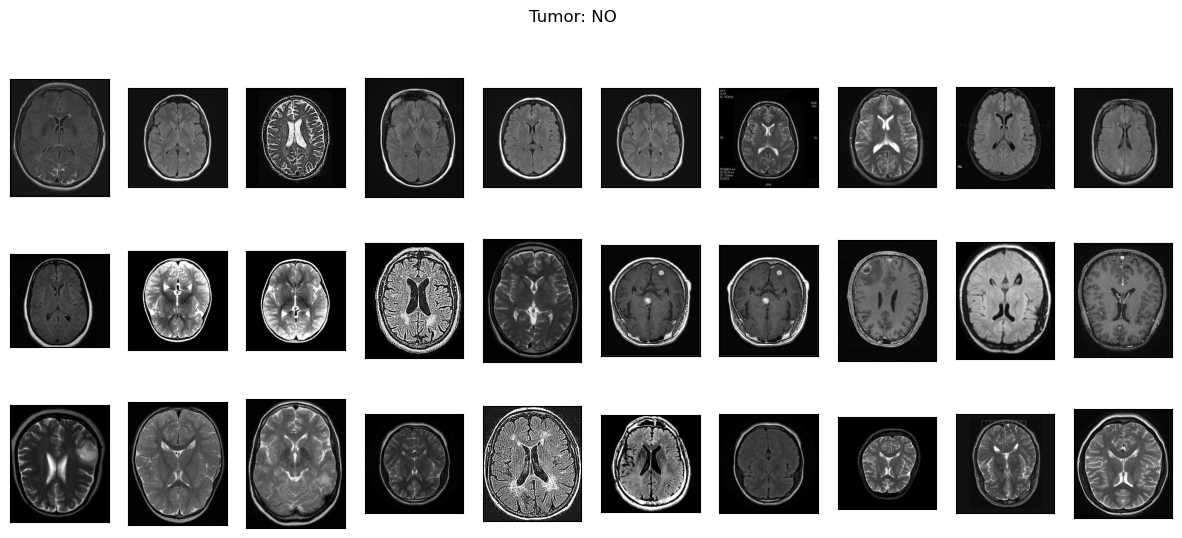

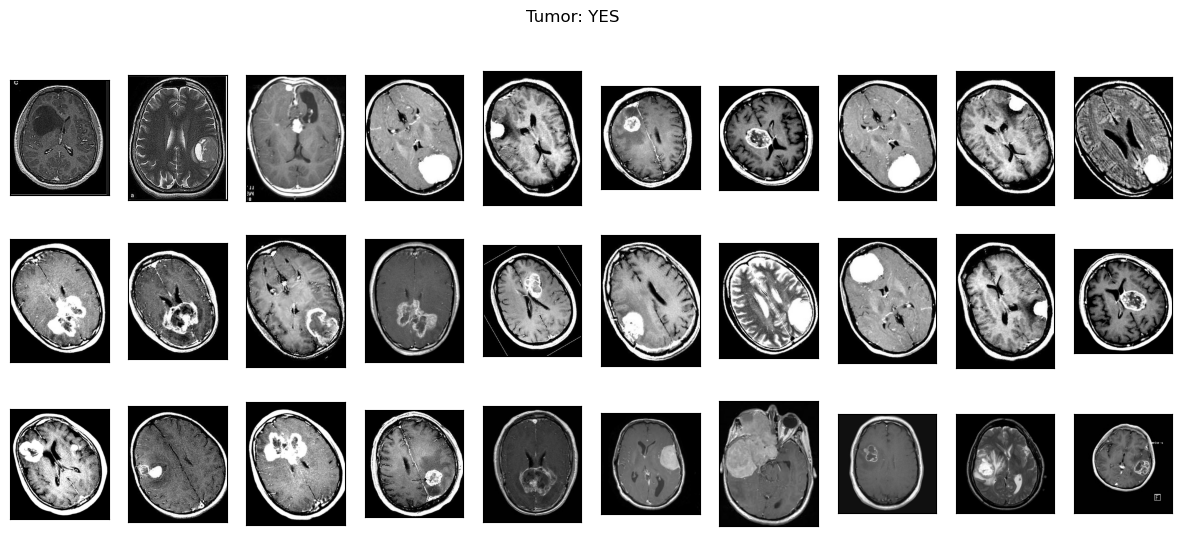

In [35]:
plot_samples(X_train, y_train, labels, 30)

In [37]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [38]:
import imutils
img = cv2.imread('./VAL/NO/no852.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

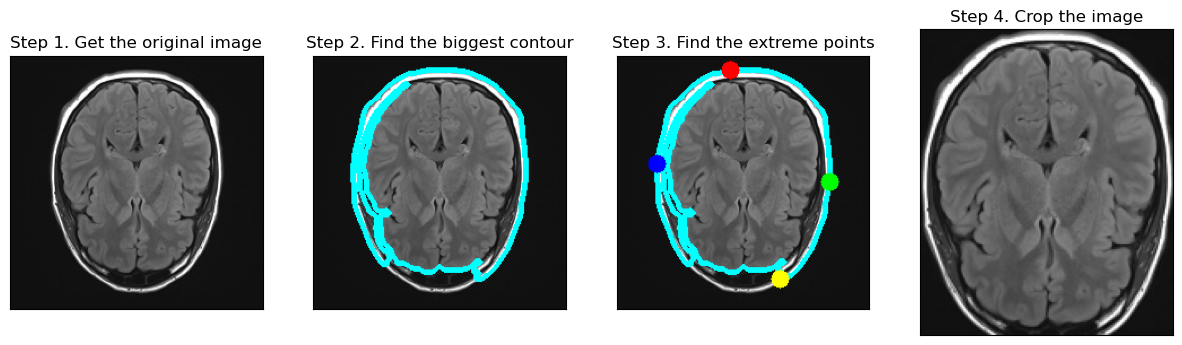

In [42]:
# Let's visualize how the cropping works
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [43]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7936\2254567846.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



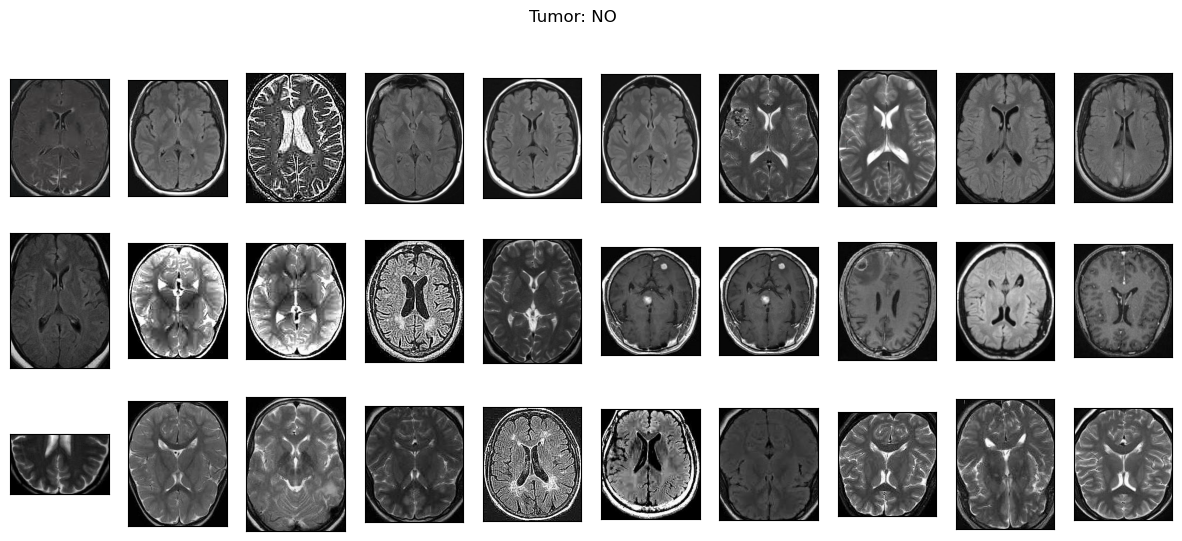

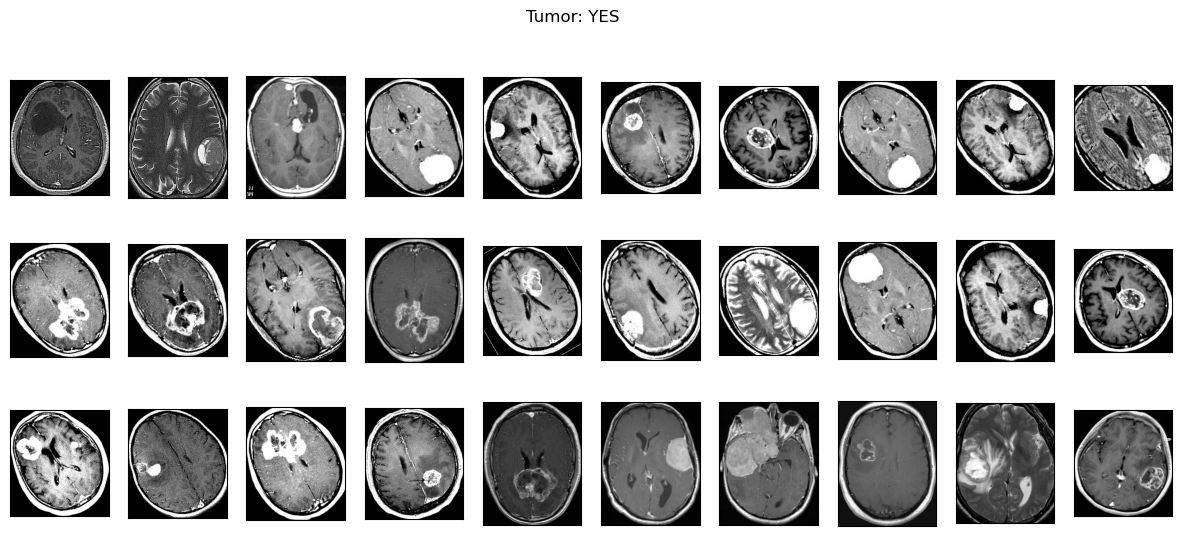

In [44]:
plot_samples(X_train_crop, y_train, labels, 30)

In [46]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [48]:
import os

# Create directories if they don't exist
folders = ['TRAIN_CROP', 'TEST_CROP', 'VAL_CROP', 'TRAIN_CROP/YES', 'TRAIN_CROP/NO', 'TEST_CROP/YES', 'TEST_CROP/NO', 'VAL_CROP/YES', 'VAL_CROP/NO']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Assuming save_new_images is defined somewhere
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


In [57]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)
# Assuming you have defined the preprocess_input function elsewhere
IMG_SIZE = (224, 224)  # Define the desired image size
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

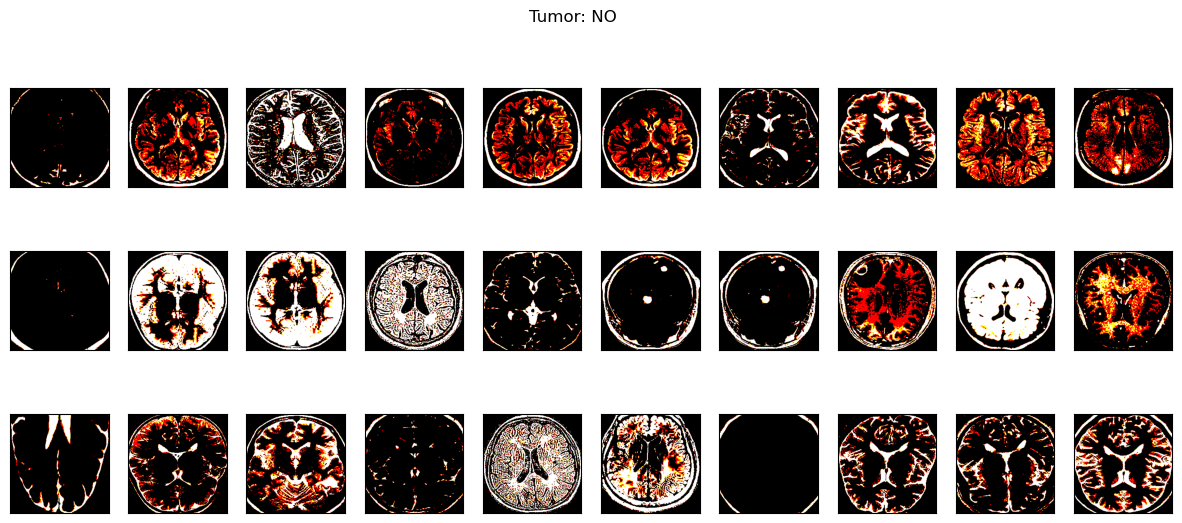

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

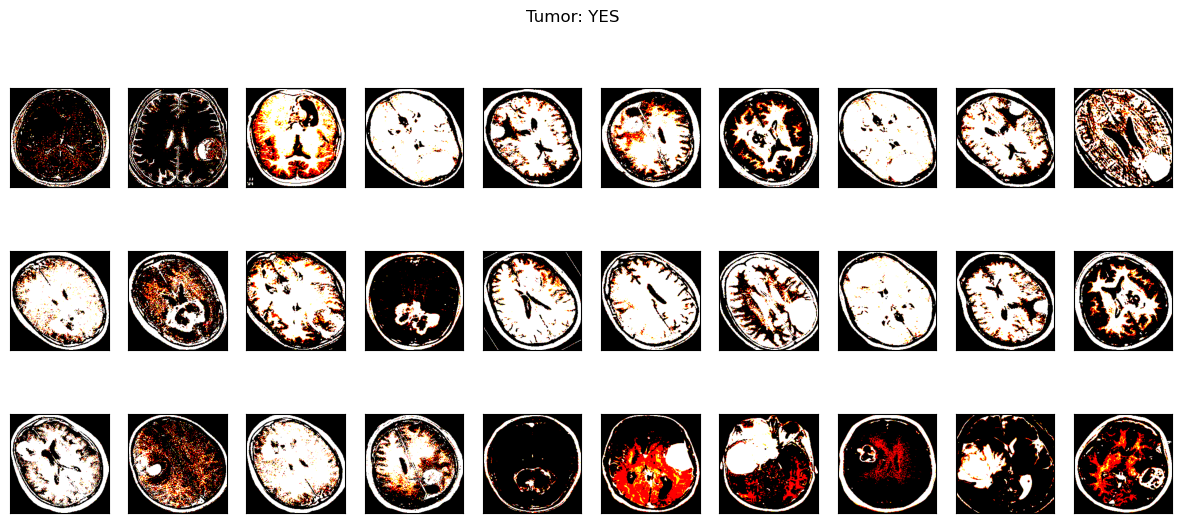

In [58]:
plot_samples(X_train_prep, y_train, labels, 30)

In [59]:
#Augmentation


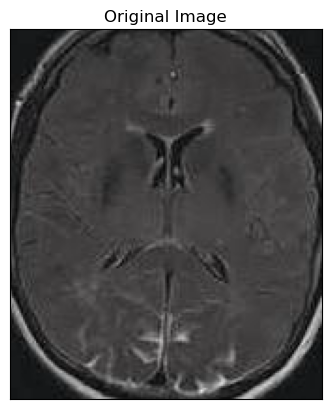

<Figure size 1500x600 with 0 Axes>

In [69]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview56')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
        
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview56/'):
    img = cv2.cv2.imread('preview56/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [73]:
rmdir /s /q preview56

In [74]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
   
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [75]:
base_Neural_Net= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 256)               0

In [76]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7936\1684825070.py:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
50/50 [==============================] - 191s 3s/step - loss: 0.3870 - accuracy: 0.8471 - auc: 0.9195 - val_loss: 0.3618 - val_accuracy: 0.9050 - val_auc: 0.9579
Epoch 2/30
50/50 [==============================] - 131s 3s/step - loss: 0.2333 - accuracy: 0.9112 - auc: 0.9668 - val_loss: 0.2115 - val_accuracy: 0.9225 - val_auc: 0.9826
Epoch 3/30
50/50 [==============================] - 142s 3s/step - loss: 0.1664 - accuracy: 0.9378 - auc: 0.9826 - val_loss: 0.1039 - val_accuracy: 0.9525 - val_auc: 0.9962
Epoch 4/30
50/50 [==============================] - 141s 3s/step - loss: 0.1417 - accuracy: 0.9454 - auc: 0.9879 - val_loss: 0.0840 - val_accuracy: 0.9650 - val_auc: 0.9985
Epoch 5/30
50/50 [==============================] - 134s 3s/step - loss: 0.1194 - accuracy: 0.9607 - auc: 0.9911 - val_loss: 0.0763 - val_accuracy: 0.9675 - val_auc: 0.9986
Epoch 6/30
50/50 [==============================] - 127s 3s/step - loss: 0.1096 - accuracy: 0.9600 - auc: 0.9919 - val_loss: 0.0772 - v

50/50 [==============================] - 131s 3s/step - loss: 0.0640 - accuracy: 0.9794 - auc: 0.9970 - val_loss: 0.0198 - val_accuracy: 0.9925 - val_auc: 1.0000
Epoch 21/30
50/50 [==============================] - 129s 3s/step - loss: 0.0535 - accuracy: 0.9835 - auc: 0.9977 - val_loss: 0.0329 - val_accuracy: 0.9900 - val_auc: 0.9998
Epoch 22/30
50/50 [==============================] - 129s 3s/step - loss: 0.0583 - accuracy: 0.9810 - auc: 0.9972 - val_loss: 0.0278 - val_accuracy: 0.9925 - val_auc: 0.9997
Epoch 23/30
50/50 [==============================] - 128s 3s/step - loss: 0.0599 - accuracy: 0.9784 - auc: 0.9975 - val_loss: 0.0249 - val_accuracy: 0.9900 - val_auc: 0.9997
Epoch 24/30
50/50 [==============================] - 131s 3s/step - loss: 0.0460 - accuracy: 0.9829 - auc: 0.9988 - val_loss: 0.0363 - val_accuracy: 0.9850 - val_auc: 0.9993
Epoch 25/30
50/50 [==============================] - 129s 3s/step - loss: 0.0586 - accuracy: 0.9778 - auc: 0.9978 - val_loss: 0.0276 - val_acc

In [77]:
history


In [78]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 50}

In [79]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

In [80]:
type(history.history['loss'])


list

In [81]:
history.history['loss'][:5]

[0.387013703584671,
 0.2333422750234604,
 0.1663513332605362,
 0.14168433845043182,
 0.1193922758102417]

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

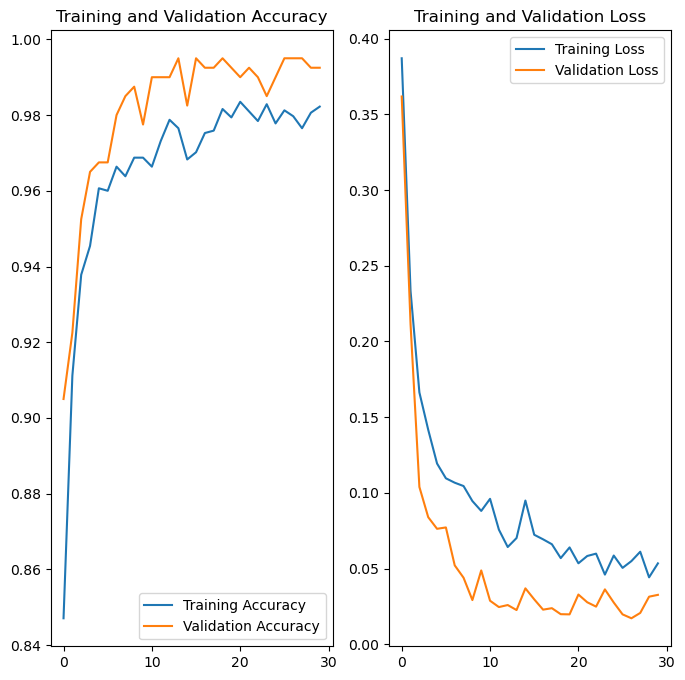

In [83]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 33s 2s/step
Test Accuracy = 0.99


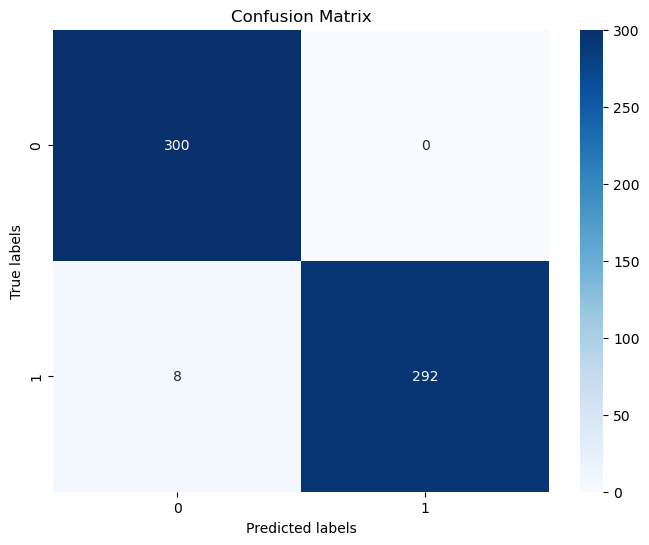

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


19/19 [==============================] - 33s 2s/step
Test Accuracy = 0.99


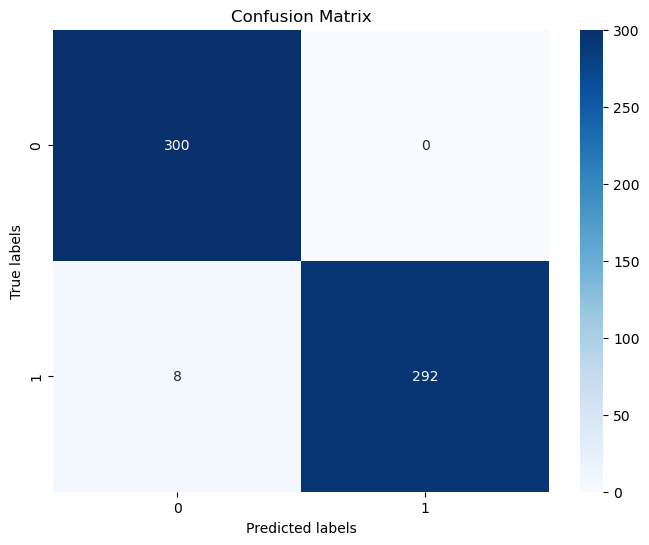

In [108]:
# Validate on the test set
predictions = model.predict(X_test_prep)

# Converting the predictions to binary values based on a threshold (0.5 in this case)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculating accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print('Test Accuracy = %.2f' % accuracy)

# Generating and displaying the confusion matrix
confusion_mtx = confusion_matrix(y_test, binary_predictions) 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



57/57 [==============================] - 115s 2s/step
Train Accuracy = 1.00


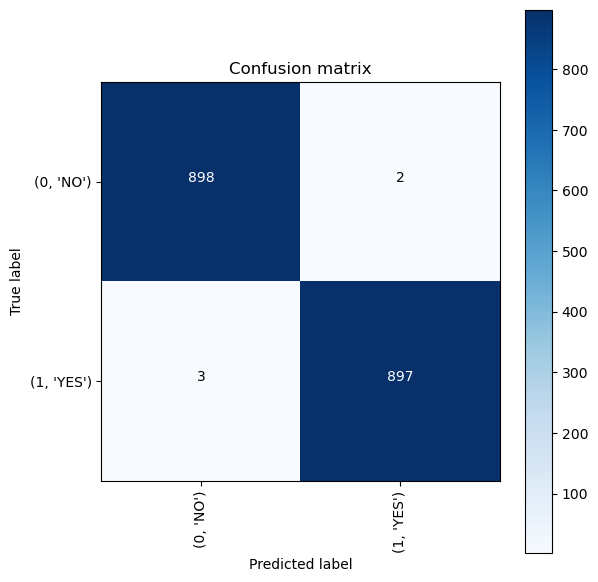

In [113]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 33s 2s/step
Val Accuracy = 0.99


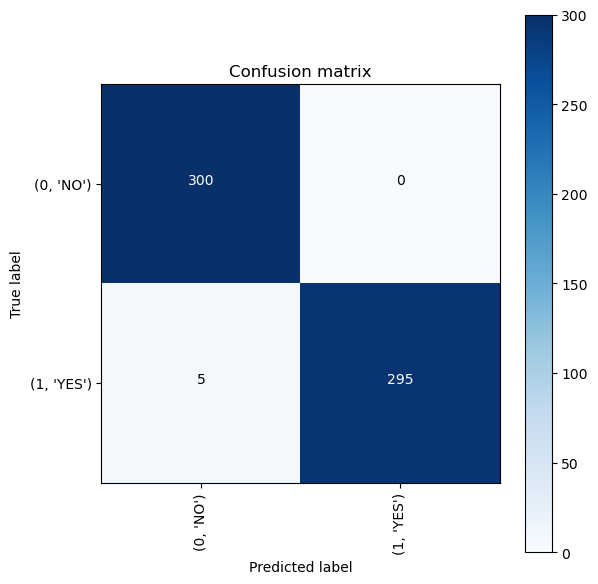

In [114]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [115]:
prob_pred = model.predict_proba(X_test_prep)

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [ ]:
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test, predictions),4))
print('Precision score is :', np.round(metrics.precision_score(y_test, predictions, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test, predictions, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test, predictions, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, predictions),4))

print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")